# Pectoral Muscle Removal from Mammograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

from bcd.utils.image import grayscale

### Ensuring same orientation of all images
In order for the algorithm to generalize over all mammograms, we first right-orient all images. To detect left-oriented breast images, we simply compare the number of nonzero pixels on both half of the images.

This is quite a rudimentary way to detect orientation, and works because the the background pixels are completely black and thus gives us an idea of the location of breast on either half of the image

In [2]:
from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = grayscale(image)
    # image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image



### Applying canny edge detection

In [3]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

### Applying Hough transform
Once we have obtained the edges using the Canny Edge Detector, we can apply Hough transform and make a list of output lines.

Each line is represented by an object with the following attributes
 - `dist`: perpendicular distance of the line from origin
 - `angle`: angle (in degrees) made by the perpendicular from the positive x-axis. This perpendicular is dropped on the line from the origin
 - `point1`, `point2`: two points on the line
 
Note: The x-axis and y-axis are oriented as shown in the image ouputs below.

In [4]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

### Shortlisting lines
We need to shortlist possible candidates for pectoral segmentation. A simple criteria for shortlisting can be simply checking whether the `angle` and `dist` values of each line lies inside a particular interval.

The intervals are `MIN_ANGLE <= angle <= MAX_ANGLE` and `MIN_DIST <= dist <= MAX_DIST`.

These 4 parameters can be easily learned given a bigger dataset of mammograms. However, for now these have been picked manually using judgement on the given 5 images, and seem to work well.

In [5]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 256
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

### Removing pectoral region
If more than one line is shortlisted, we select the one which will cause the least loss of information (the safest approach).

For this, we sort these lines by their distance from origin `dist` and pick the nearest line. Then we simply set the value to zero of those pixels enclosed within a polygon formed by the picked line and the border of the image.

In [6]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

### Displaying final result
The result for all the five images is displayed below. We can easily compare the removed pectoral area with the original image.

In [7]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show()    


All hough lines
Angle: 89.00, Dist: 115.00
Angle: 88.00, Dist: 135.00
Angle: 87.00, Dist: 158.00
Angle: -90.00, Dist: -101.00

Shorlisted lines


IndexError: list index out of range

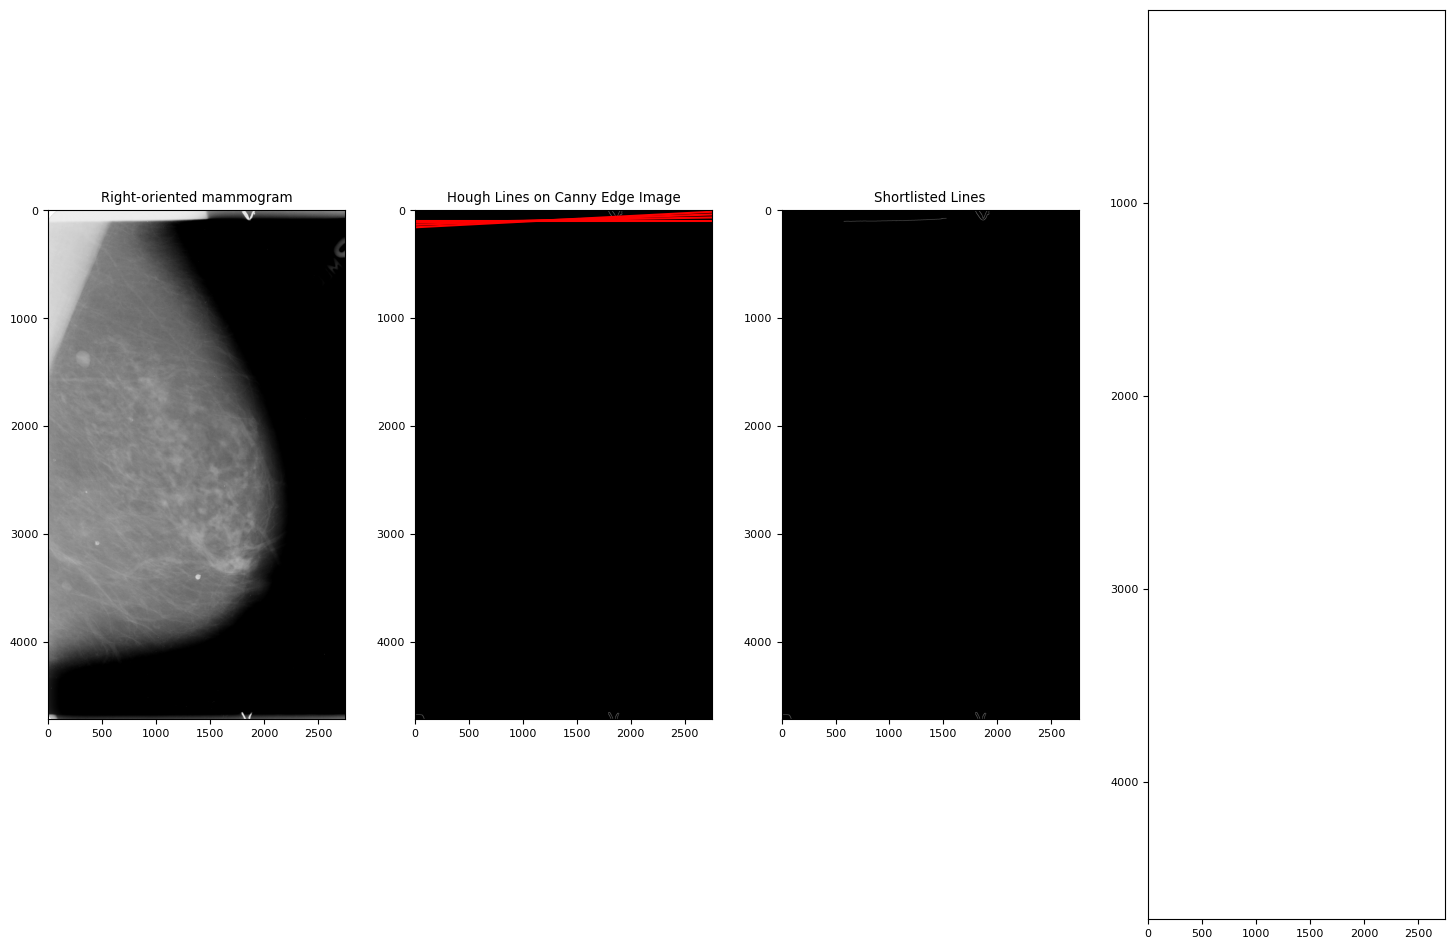

In [8]:
display_image("data/image/1_dev/converted/train/benign/82dcf0a8-cfb0-4446-97e4-a561893e334b.png")

In [ ]:
display_image("data/image/1_dev/converted/train/benign/2a458310-ed63-46ed-b18a-3e9790e2c182.png")

In [ ]:
display_image("data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png")

In [ ]:
display_image("data/image/1_dev/converted/train/benign/a2c62f57-14c7-4ac1-b763-b18797847af0.png")

In [ ]:
display_image('mammo_5.jpg')

### Scope for improvement
- The algorothm seems to produce satisfactory result on the images. However, not so much on the last image, `mammo_5.jpg`. This is so because the pectoral region here can not simply be modelled by a single line.
- We can try to apply this algorithm again on such images, and try to chisel away remaining parts of the pectoral muscle in each iteration
- The parameters for the shortlisting lines have been chosen manually. However, they can be easily learned given a bigger dataset.